In [1]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')

GPU0 Memory: 10479MB


# 导入必要的库

17


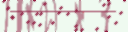

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from tqdm import tqdm
import pandas as pd
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
digits = string.digits
operators = '+-*'
characters = digits + operators + '()='
characters+='a'#CTC用 占位符

char_to_id = {j:i for i,j in enumerate(characters)}
id_to_char = {i:j for i,j in enumerate(characters)}
extra_char_id = char_to_id['a']

width, height, n_len, n_class = 128, 32, 11, len(characters)
print(n_class)

from IPython.display import display
generator = ImageCaptcha(width=width, height=height, font_sizes=range(35, 56), 
                         fonts=['fonts/%s'%x for x in os.listdir('fonts') if '.tt' in x])
display(generator.generate_image('(1+2)*3'))

# 常量设置

In [4]:
prefix = '6.'

# 数据集划分

In [5]:
from sklearn.model_selection import train_test_split
root_path = 'G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/'
data_csv = pd.read_csv(root_path + 'train.csv')
img_dirpath = data_csv['filename'].tolist()
label = data_csv['label'].tolist()
X_data, X_valid, y_data, y_valid = train_test_split(img_dirpath, label, test_size=10000, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10000, random_state=17)

# 定义 CTC Loss

In [7]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage:
    # 由于我们使用的是循环神经网络，所以默认丢掉前面两个输出，因为它们通常无意义，且会影响模型的输出
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


# 模型结构

In [8]:
from keras.layers import *
from keras.models import *
from make_parallel import make_parallel
rnn_size = 128

input_tensor = Input((width, height, 1))# (128,64,1)
x = input_tensor

# 1
x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层
# 2
x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层
# 3
x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x) # 加入 , padding='same'
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.2)(x) # 模型有过拟合的倾向，加入dropout层

# CNN to RNN
conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x) #  Flatten

x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# RNN layer
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])
gru1_merged = BatchNormalization()(gru1_merged)

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
             name='gru2_b')(gru1_merged)
x = concatenate([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
# 预测
base_model = Model(input=input_tensor, output=x)

# base_model2 = make_parallel(base_model, 4)

labels = Input(name='the_labels', shape=[n_len], dtype='float32') # (None ,11)
input_length = Input(name='input_length', shape=(1,), dtype='int64')# (None, 1)？？？？
label_length = Input(name='label_length', shape=(1,), dtype='int64')# (None, 1)？？？？
# Keras doesn't currently support loss funcs with extra parameters so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func, name='ctc')([base_model.output, labels, input_length, label_length]) #(None, 1)

# 训练
model = Model(inputs=(input_tensor, labels, input_length, label_length), outputs=loss_out)

# 1.把目标当成一个输入，构成多输入模型，把loss写成一个层，作为最后的输出，搭建模型的时候，就只需要将模型的output定义为loss，
# 而compile的时候，直接将loss设置为y_pred（因为模型的输出就是loss，所以y_pred就是loss），无视y_true，
# 训练的时候，y_true随便扔一个符合形状的数组进去就行了
# 2.为了避免手动调参，我们使用了 Adam 优化器，它的学习率是自动设置的，我们只需要给一个较好的初始学习率即可
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

d:\ProgramData\Anaconda3\envs\captcha_demo\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


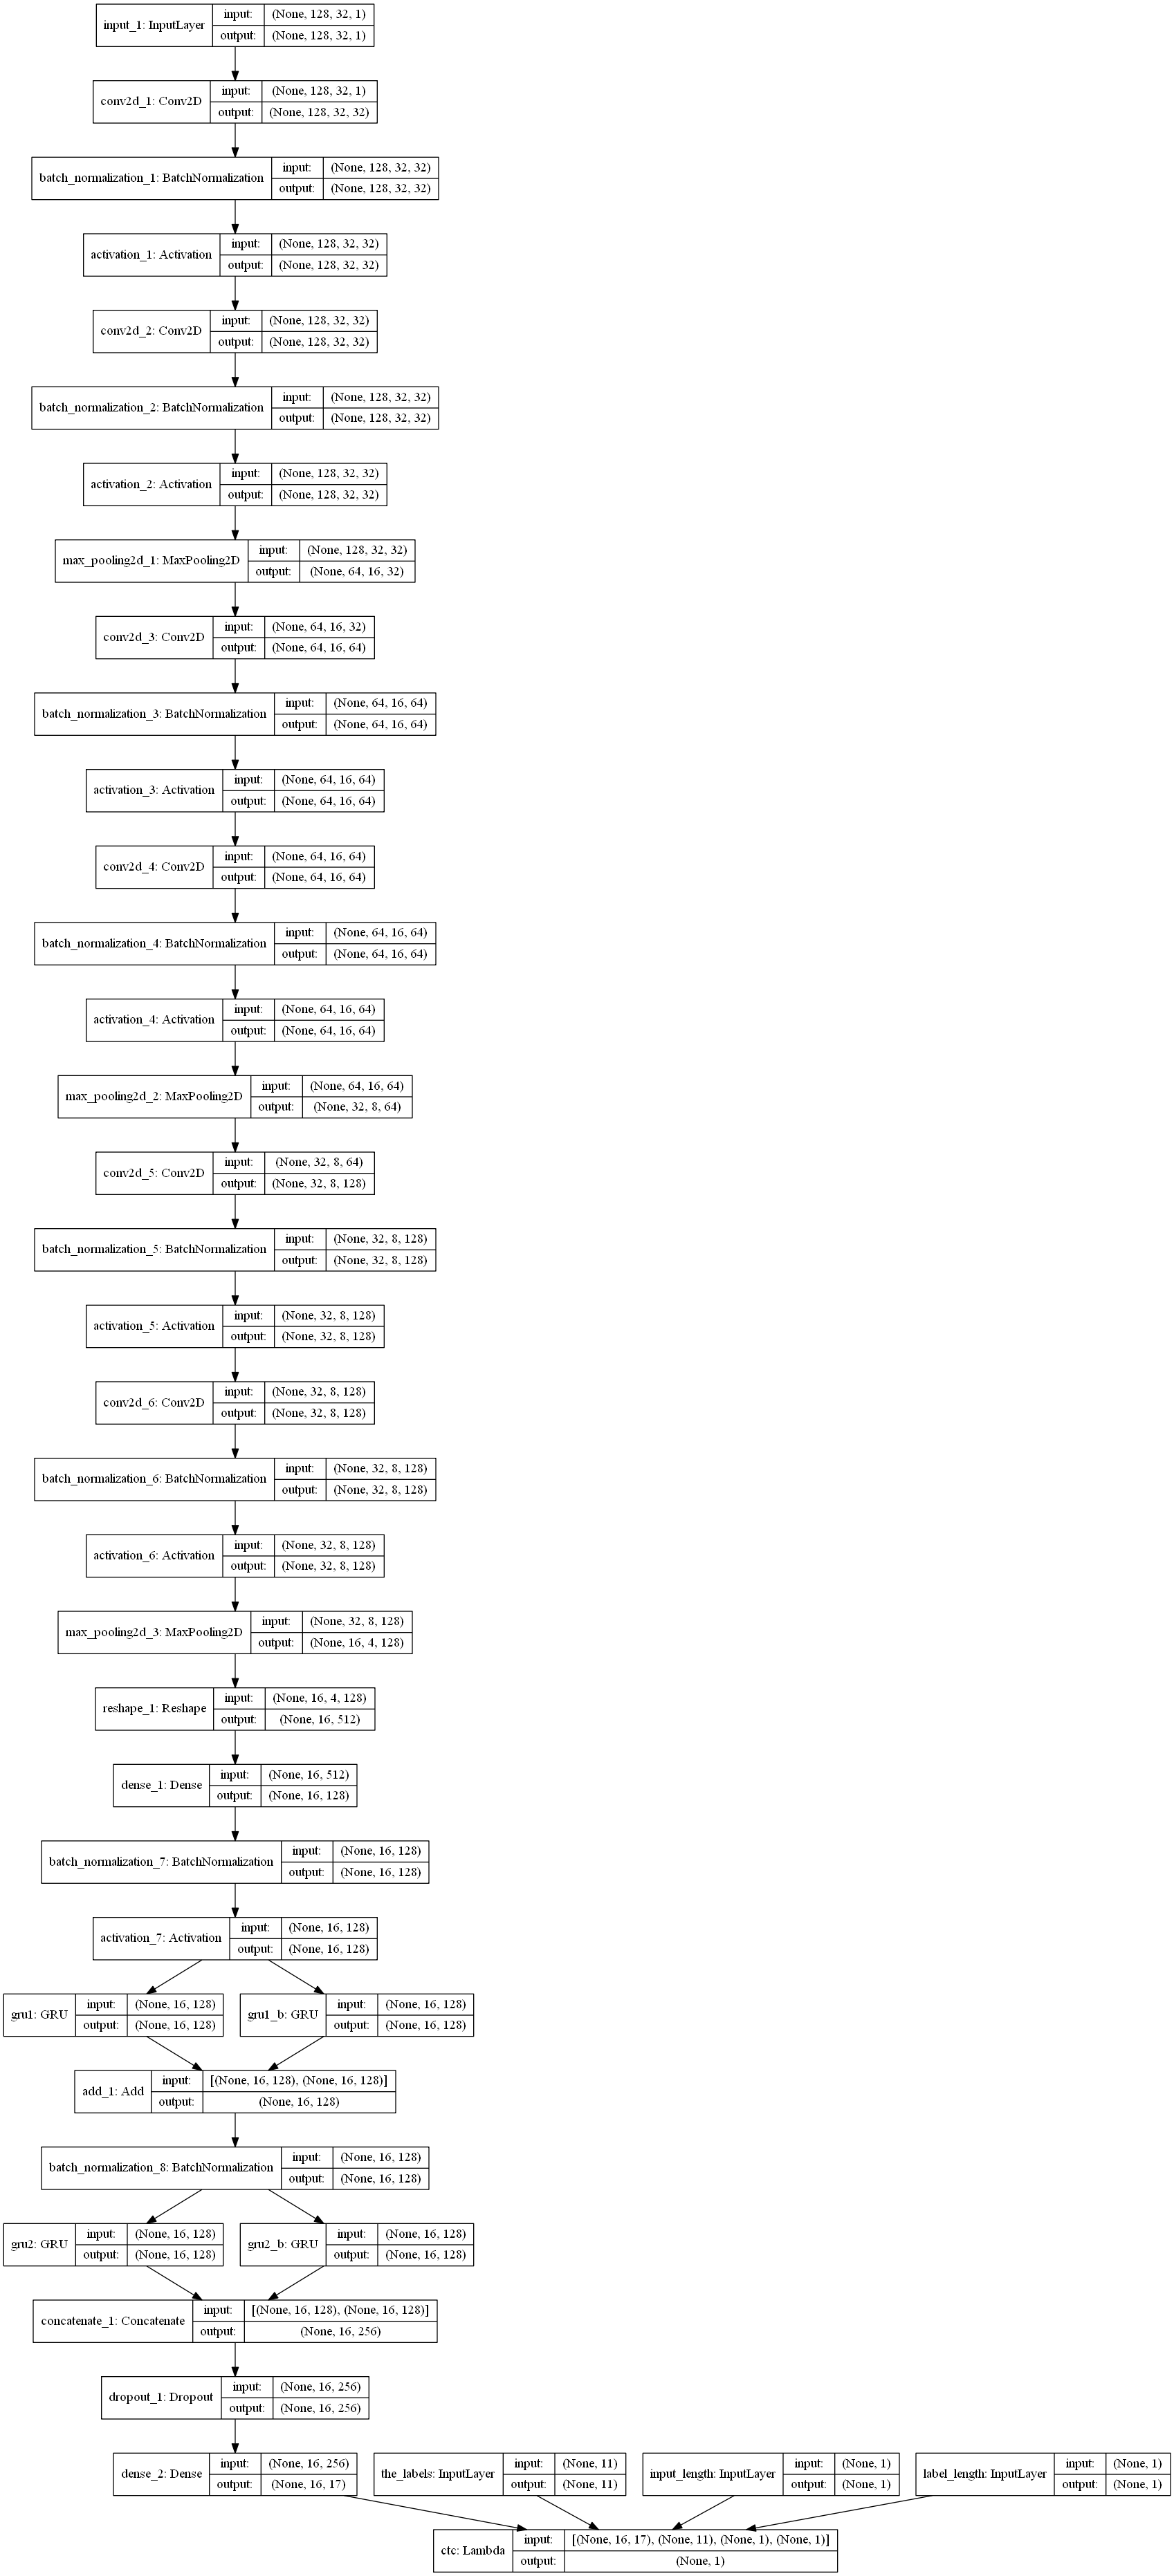

In [9]:
from IPython.display import Image
from keras.utils import plot_model
plot_model(model, to_file=(prefix + 'model.png'), show_shapes=True)

#plot(model, to_file="model.png", show_shapes=True)
Image(prefix + 'model.png')

# 绘制准确率

In [10]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig("Training and validation accuracy.png")
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig("Training and validation loss.png")
    plt.show()

# 数据生成器定义

In [11]:
n_train = len(X_train)
print(n_train)
X_train_data = np.zeros((n_train, height, width))
y_train_data = np.zeros((n_train, n_len), dtype=np.int32)
label_length_train = np.zeros((n_train, 1), dtype=np.int32)

for i,item in tqdm(enumerate(X_train)):
    img = cv2.imread(root_path + item, 
                     cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (width, height))
    img = img.astype(np.float32)
    img = (img / 255.0) * 2.0 - 1.0 # 归一化
    # 输入的时候是经过了旋转的，这是因为我们希望以水平方向输入循环神经网络，
    # 而图片在 numpy 里默认是这样的形状：(height, width, 3)，因此我们使用了 transpose 函数将图片转为了(width, height, 3)的格式，
    # 这样就能把 X 轴转到第一个维度，方便输入到循环神经网络
#     X_train_data[i] = img[:,:,::-1].transpose(1, 0, 2)#将图像逆时针旋转90度后，上下翻转
    X_train_data[i, :, :] = img
    random_str = y_train[i]
    y_train_data[i,:len(random_str)] = [char_to_id[x] for x in random_str]
    y_train_data[i,len(random_str):] = extra_char_id # 空白用占位字符
    label_length_train[i] = len(random_str)

80000


80000it [00:20, 3978.47it/s]


In [12]:
shuffle_indexes = list(range(len(X_train))) # 初始化为顺序
count = 0
def gen(batch_size=128):
    X = np.zeros((batch_size, width, height, 1), dtype=np.float32)
    y = np.zeros((batch_size, n_len), dtype=np.int32)
    label_length = np.ones(batch_size)
    global count
    while True:
        for i in range(batch_size):
            index = batch_size*count + i
            # 如果超过
            if index >= len(X_train):
                count = 0
                random.shuffle(shuffle_indexes) # 超过最大数量后，打乱排序，再训练
                index = batch_size*count + i
            shuffle_index = shuffle_indexes[index]
            img_file_name = X_train[shuffle_index]
            tem_str = y_train[shuffle_index]
            
            # 输入的时候是经过了旋转的，这是因为我们希望以水平方向输入循环神经网络，
            # 而图片在 numpy 里默认是这样的形状：(height, width, 3)，因此我们使用了 transpose 函数将图片转为了(width, height, 3)的格式，
            # 这样就能把 X 轴转到第一个维度，方便输入到循环神经网络
            img = X_train_data[shuffle_index].T
            img = np.expand_dims(img, -1)
            X[i] = img
            y[i,:] = y_train_data[shuffle_index]

            label_length[i] = label_length_train[shuffle_index]
        count = count + 1
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), label_length], np.ones(batch_size)


# 验证函数和回调函数

In [14]:
n_valid = len(X_valid)
print(n_valid)
X_valid_data = np.zeros((n_valid, width, height, 1))
y_valid_data = np.zeros((n_valid, n_len), dtype=np.int32)
label_length_valid = np.zeros((n_valid, 1), dtype=np.int32)

for i,item in tqdm(enumerate(X_valid)):
    img = cv2.imread(root_path + item, 
                     cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (width, height))
    img = img.astype(np.float32)
    img = (img / 255.0) * 2.0 - 1.0 # 归一化
    
    # 输入的时候是经过了旋转的，这是因为我们希望以水平方向输入循环神经网络，
    # 而图片在 numpy 里默认是这样的形状：(height, width, 3)，因此我们使用了 transpose 函数将图片转为了(width, height, 3)的格式，
    # 这样就能把 X 轴转到第一个维度，方便输入到循环神经网络
#     X_valid_data[i] = img[:,:,::-1].transpose(1, 0, 2)#将图像逆时针旋转90度后，上下翻转
    img = img.T
    img = np.expand_dims(img, -1)
    X_valid_data[i] = img
    random_str = y_valid[i]
    y_valid_data[i,:len(random_str)] = [char_to_id[x] for x in random_str]
    y_valid_data[i,len(random_str):] = extra_char_id # 空白用占位字符
    label_length_valid[i] = len(random_str)

10000


10000it [00:02, 3892.37it/s]


# 训练

In [15]:
from keras.optimizers import *
from keras.callbacks import *

batch_size = 128

try:
    model.load_weights(prefix + 'model_gru_best.h5')
    print("...Previous weight data...")
except:
    print("...New weight data...")
    pass

#compile的时候，直接将loss设置为y_pred（因为模型的输出就是loss，所以y_pred就是loss），
#无视y_true，训练的时候，y_true随便扔一个符合形状的数组进去就行了
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3))#lr先设成Adam(1e-3)快速试错，看能否收敛#optimizer=Adam(1e-4))
h1 = model.fit_generator(gen(batch_size), 
#                         workers=4,# workers=4 参数让 Keras 自动实现多进程生成数据，摆脱 python 单线程效率低的缺点
                        verbose = 2,
                        #use_multiprocessing=False,
                        validation_data=([X_valid_data, y_valid_data, np.ones(n_valid)*int(conv_shape[1]-2), label_length_valid], np.ones(n_valid)), 
                        steps_per_epoch=len(X_train)/batch_size, 
                        epochs=20, #调试只设1代，正常50到150
                        
                        # 为了避免手动调参，我们使用了 Adam 优化器，它的学习率是自动设置的，我们只需要给一个较好的初始学习率即可。
                        # EarlyStopping 是一个 Keras 的 Callback，它可以在 loss 超过多少个 epoch 没有下降以后，就自动终止训练，避免浪费时间。
                        # ModelCheckpoint 是另一个好用的 Callback，它可以保存训练过程中最好的模型。
                        # CSVLogger 可以记录 loss 为 CSV 文件，这样我们就可以在训练完成以后绘制训练过程中的 loss 曲线。
                        callbacks=[EarlyStopping(patience=3), CSVLogger(prefix + 'crnn.csv'), ModelCheckpoint(prefix + 'model_gru_best1.h5', save_best_only=True, verbose=0)]
                       )

...New weight data...
Epoch 1/20
 - 87s - loss: 4.9386 - val_loss: 3.2811
Epoch 2/20
 - 83s - loss: 0.9655 - val_loss: 0.6876
Epoch 3/20
 - 83s - loss: 0.8484 - val_loss: 0.3295
Epoch 4/20
 - 83s - loss: 0.8245 - val_loss: 0.2553
Epoch 5/20
 - 84s - loss: 0.7661 - val_loss: 0.2321
Epoch 6/20
 - 83s - loss: 0.7304 - val_loss: 3.6669
Epoch 7/20
 - 84s - loss: 0.7524 - val_loss: 0.2004
Epoch 8/20
 - 83s - loss: 0.7693 - val_loss: 0.3178
Epoch 9/20
 - 83s - loss: 0.6029 - val_loss: 0.2020
Epoch 10/20
 - 83s - loss: 0.5857 - val_loss: 0.2616


In [16]:
model.load_weights(prefix + 'model_gru_best1.h5')
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-4))
h2 = model.fit_generator(gen(batch_size), 
#                         workers=4,# workers=4 参数让 Keras 自动实现多进程生成数据，摆脱 python 单线程效率低的缺点
                        verbose = 2,
                        #use_multiprocessing=False,
                        validation_data=([X_valid_data, y_valid_data, np.ones(n_valid)*int(conv_shape[1]-2), label_length_valid], np.ones(n_valid)), 
                        steps_per_epoch=len(X_train)/batch_size, 
                        epochs=20, #调试只设1代，正常50到150
                        
                        # 为了避免手动调参，我们使用了 Adam 优化器，它的学习率是自动设置的，我们只需要给一个较好的初始学习率即可。
                        # EarlyStopping 是一个 Keras 的 Callback，它可以在 loss 超过多少个 epoch 没有下降以后，就自动终止训练，避免浪费时间。
                        # ModelCheckpoint 是另一个好用的 Callback，它可以保存训练过程中最好的模型。
                        # CSVLogger 可以记录 loss 为 CSV 文件，这样我们就可以在训练完成以后绘制训练过程中的 loss 曲线。
                        callbacks=[EarlyStopping(patience=3), CSVLogger(prefix + 'crnn.csv', append=True), ModelCheckpoint(prefix + 'model_gru_best2.h5', save_best_only=True, verbose=0)]
                       )

Epoch 1/20
 - 87s - loss: 0.6502 - val_loss: 0.1228
Epoch 2/20
 - 84s - loss: 0.5896 - val_loss: 0.1117
Epoch 3/20
 - 83s - loss: 0.6726 - val_loss: 0.1132
Epoch 4/20
 - 84s - loss: 0.6321 - val_loss: 0.1108
Epoch 5/20
 - 85s - loss: 0.5896 - val_loss: 0.0986
Epoch 6/20
 - 84s - loss: 0.7239 - val_loss: 0.1237
Epoch 7/20
 - 84s - loss: 0.6138 - val_loss: 0.1151
Epoch 8/20
 - 83s - loss: 0.6771 - val_loss: 0.1206


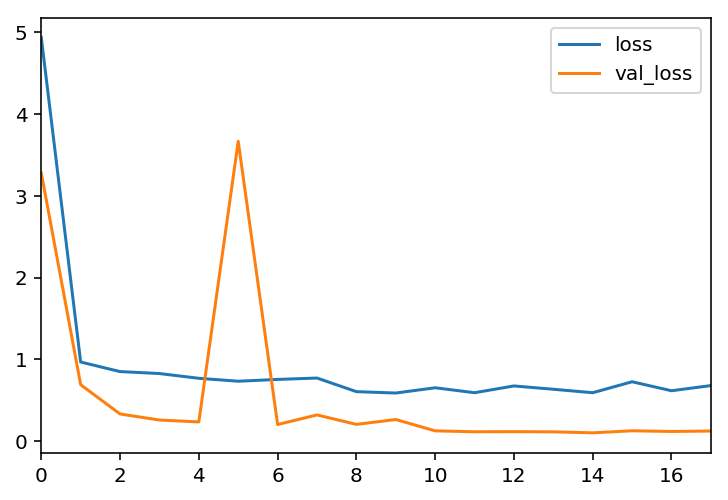

In [17]:
df = pd.read_csv(prefix + 'crnn.csv')
df[['loss', 'val_loss']].plot()

# 准确率

In [18]:
import itertools

def decode_label(out):
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    outstr = ''.join([characters[x] for x in out_best if x > -1 and x < 16])
    return outstr

total = 0
acc = 0
letter_total = 0
letter_acc = 0

model.load_weights(prefix + 'model_gru_best2.h5')

for i, img_file in tqdm(enumerate(X_test)):
    img = cv2.imread(root_path + img_file, 
                     cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (width, height))
    img = img.astype(np.float32)
    img = (img / 255.0) * 2.0 - 1.0 # 归一化
    
    X = np.zeros((1, width, height, 1))
#     X[0] = np.array(img[:,:,::-1]).transpose(1, 0, 2)
    img = img.T
    img = np.expand_dims(img, -1)
    X[0] = img

    net_out_value = base_model.predict(X)
    pred_texts = decode_label(net_out_value)
    for j in range(min(len(pred_texts), len(y_test[i]))):
        if pred_texts[j] == y_test[i][j]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(y_test[i]))

    if pred_texts == y_test[i]:
        acc += 1
    total += 1

print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

10000it [02:10, 76.59it/s]


ACC :  0.9833
letter ACC :  0.9975887165145393
